In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import torchaudio
from torch.utils.data import DataLoader, Dataset
import os
from asteroid.metrics import get_metrics
from asteroid.losses import singlesrc_neg_sisdr, singlesrc_neg_snr

import numpy as np
import matplotlib.pyplot as plt
from glob import glob

from IPython.display import Audio
from tqdm import tqdm
import time

In [2]:
import torchaudio.transforms
import torch.nn as nn

sr = 48000

# mel_spectrogram = nn.Sequential(
#         AT.MelSpectrogram(sample_rate=sr,
#                         n_fft=512,
#                         win_length=400,
#                         hop_length=160,
#                         n_mels=40),
#     AT.AmplitudeToDB()
# )

In [57]:
def get_mgrid(sidelen, dim=2):
    '''Generates a flattened grid of (x,y,...) coordinates in a range of -1 to 1.
    sidelen: int
    dim: int'''
    tensors = tuple([torch.linspace(-1, 1, steps=sidelen[0])] + [torch.linspace(-1, 1, steps=sidelen[1])])
    mgrid = torch.stack(torch.meshgrid(*tensors), dim=-1)
    mgrid = mgrid.reshape(-1, dim)
    return mgrid

# def get_mgrid(melspec, dim=2):
#     coordinates = torch.ones(melspec.shape[1:]).nonzero(as_tuple=False).float()
#     coordinates = coordinates / (melspec.shape[1] - 1) - 0.5
#     coordinates *= 2
#     print("coordinates shape : ",coordinates.shape)
#     return coordinates
    
class SineLayer(nn.Module):
    def __init__(self, in_features, out_features, bias=True,
                 is_first=False, omega_0=30):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first
        
        self.in_features = in_features
        self.linear = nn.Linear(in_features, out_features, bias=bias)
        
        self.init_weights()
    
    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.in_features, 
                                             1 / self.in_features)      
            else:
                self.linear.weight.uniform_(-np.sqrt(6 / self.in_features) / self.omega_0, 
                                             np.sqrt(6 / self.in_features) / self.omega_0)
        
    def forward(self, input):
        return torch.sin(self.omega_0 * self.linear(input))
    
    def forward_with_intermediate(self, input): 
        # For visualization of activation distributions
        intermediate = self.omega_0 * self.linear(input)
        return torch.sin(intermediate), intermediate
    
    
class Siren(nn.Module):
    def __init__(self, in_features, hidden_features, hidden_layers, out_features, outermost_linear=False, 
                 first_omega_0=30, hidden_omega_0=30.):
        super().__init__()
        
        self.net = []
        self.net.append(SineLayer(in_features, hidden_features, 
                                  is_first=True, omega_0=first_omega_0))

        for i in range(hidden_layers):
            self.net.append(SineLayer(hidden_features, hidden_features, 
                                      is_first=False, omega_0=hidden_omega_0))

        if outermost_linear:
            final_linear = nn.Linear(hidden_features, out_features)
            
            with torch.no_grad():
                final_linear.weight.uniform_(-np.sqrt(6 / hidden_features) / hidden_omega_0, 
                                              np.sqrt(6 / hidden_features) / hidden_omega_0)
                
            self.net.append(final_linear)
        else:
            self.net.append(SineLayer(hidden_features, out_features, 
                                      is_first=False, omega_0=hidden_omega_0))
        
        self.net = nn.Sequential(*self.net)
    
    def forward(self, coords):
        coords = coords.clone().detach().requires_grad_(True) # allows to take derivative w.r.t. input
        output = self.net(coords)
        return output, coords        

    def forward_with_activations(self, coords, retain_grad=False):
        '''Returns not only model output, but also intermediate activations.
        Only used for visualizing activations later!'''
        activations = {}

        activation_count = 0
        x = coords.clone().detach().requires_grad_(True)
        activations['input'] = x
        for i, layer in enumerate(self.net):
            if isinstance(layer, SineLayer):
                x, intermed = layer.forward_with_intermediate(x)
                
                if retain_grad:
                    x.retain_grad()
                    intermed.retain_grad()
                    
                activations['_'.join((str(layer.__class__), "%d" % activation_count))] = intermed
                activation_count += 1
            else: 
                x = layer(x)
                
                if retain_grad:
                    x.retain_grad()
                    
            activations['_'.join((str(layer.__class__), "%d" % activation_count))] = x
            activation_count += 1

        return activations


class AudioFile(torch.utils.data.Dataset):
    def __init__(self, filename):
        self.data, self.rate = torchaudio.load(filename, normalize=False)
        self.data = self.data.transpose(-1,-2).numpy()[...,0]
        # self.data = self.data.astype(np.float16)
        self.timepoints = get_mgrid(len(self.data), 1)

    def get_num_samples(self):
        return self.timepoints.shape[0]

    def __len__(self):
        return 1

    def __getitem__(self, idx):
        amplitude = self.data
        amplitude = (amplitude / 32768.)
        amplitude = torch.Tensor(amplitude).view(-1, 1)

        amplitude = amplitude / amplitude.abs().max()
        return self.timepoints, amplitude

def spectrogram(wav):
    stft = torchaudio.transforms.Spectrogram(n_fft=1024)(wav)[0]
    stft = torchaudio.transforms.AmplitudeToDB(top_db=80)(stft).numpy()
    stft = stft[::-1]
    fig = plt.figure(figsize=(20,10))
    im = plt.imshow(stft)
    plt.colorbar(im)
    
#############################################################################  

class AudioFile4MelSpec(torch.utils.data.Dataset):
    def __init__(self, filename):
        self.data, self.rate = torchaudio.load(filename, normalize=False)
#         self.melspec = torchaudio.transforms.MelSpectrogram(48000, n_fft=512, n_mels=80)(self.data)
#         print("melspec shape : ", self.melspec.shape)
        # self.data = self.data.astype(np.float16)
        
        self.melspec = torchaudio.transforms.MelSpectrogram(48000, n_fft=512, n_mels=80)(self.data)
        print("melspec shape", self.melspec.shape)
        self.coordinates = get_mgrid(self.melspec.shape[1:], 2)
        self.shape = self.melspec.shape[1:]
        #self.coordinates = self.coordinates[...,:1]

    def get_num_samples(self):
        return self.coordinates.shape[0]

    def __len__(self):
        return 1

    def __getitem__(self, idx):
        if idx > 0: raise IndexError
        
        return self.coordinates, self.melspec

In [58]:
# bit = torchaudio.backend.sox_io_backend.info(os.path.join(datapath, 'all_mono.wav')).bits_per_sample
datapath = 'C:/Users/Yoon/Desktop/INR_음성'
    
audio, rate = torchaudio.load(os.path.join(datapath, 'all_mono_0.wav'), normalize=False)
# for idx, i in enumerate(range(0, audio.shape[-1], rate * 10)):
#     torchaudio.save(os.path.join(datapath, f'all_mono_{idx}.wav'), audio[:, i:i+rate*10], sample_rate=rate)



In [22]:
audio.shape

torch.Size([1, 480000])

In [6]:
melspec = torchaudio.transforms.MelSpectrogram(48000, n_fft=512)(audio)

c:\users\yoon\appdata\local\programs\python\python37\lib\site-packages\torchaudio\functional\functional.py:508: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (257) may be set too low.
  "At least one mel filterbank has all zero values. "


In [7]:
melspec.reshape(-1,1).shape

torch.Size([240128, 1])

In [26]:
melspec.shape

torch.Size([1, 128, 1876])

In [34]:
melspec[0]

tensor([[-64.7125, -49.0485, -44.0750,  ..., -16.2432, -15.1434, -15.1447],
        [-65.2663, -49.8303, -44.2795,  ..., -17.1337, -16.2362, -16.2685],
        [-70.0858, -56.8328, -47.2210,  ..., -25.5872, -31.6626, -26.9972],
        ...,
        [-61.8620, -59.9381, -50.6104,  ..., -24.7710, -24.2369, -25.0626],
        [-61.1269, -58.5470, -51.6667,  ..., -29.4719, -28.9445, -25.4422],
        [-62.3545, -62.6609, -58.6694,  ..., -43.9952, -42.9630, -26.5210]])

In [33]:
melspec[0][0]

tensor([-64.7125, -49.0485, -44.0750,  ..., -16.2432, -15.1434, -15.1447])

In [59]:
datapath2 = 'C:/Users/Yoon/Desktop/INR_음성/all_mono_0.wav'

In [8]:
rate

48000

In [ ]:
wavpath = sorted(glob(os.path.join(datapath, f'all_mono_*.wav')), key=lambda x: int(os.path.basename(x).split('.')[0].split('_')[-1]))

In [ ]:
wavpath

In [25]:
torch.cuda.is_available()

True

In [ ]:
torch.cuda.current_device()

In [ ]:
#os.environ["CUDA_VISIBLE_DEVICES"]= "0"

In [60]:
total_steps = 2000
steps_til_summary = 1000

pesq = []
losses = []
lr = 1e-4
#for wave in wavpath:
#bach_audio = AudioFile(wave)
bach_audio = AudioFile4MelSpec(datapath2)

melspec shape torch.Size([1, 80, 1876])


In [61]:
bach_audio.melspec.shape

torch.Size([1, 80, 1876])

In [62]:
bach_audio.coordinates.shape

torch.Size([150080, 2])

In [63]:
audio_siren = Siren(in_features=2, out_features=1, hidden_features=256,   # time이 input일때는 in_feat = 1
                    hidden_layers=3, outermost_linear=True)
audio_siren = audio_siren.cuda()

In [64]:
dataloader = DataLoader(bach_audio, shuffle=True, batch_size=1, pin_memory=True, num_workers=0)

model_input, ground_truth = next(iter(dataloader))
model_input, ground_truth = model_input.cuda(), ground_truth.cuda()

In [65]:
model_input.shape, ground_truth.shape

(torch.Size([1, 150080, 2]), torch.Size([1, 1, 80, 1876]))

In [51]:
model_input.is_cuda

True

In [68]:
ground_truth = ground_truth.reshape(1, 1, -1).transpose(-1,-2)

In [69]:
ground_truth.shape

torch.Size([1, 150080, 1])

In [67]:
model_output.shape

torch.Size([1, 150080, 1])

In [70]:
optim = torch.optim.Adam(lr=lr, params=audio_siren.parameters())
decay = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, factor=1/2**0.5, patience=20, verbose=False)

minloss = torch.inf
with tqdm(range(total_steps)) as pbar:
    for step in pbar:
        optim.zero_grad()
        model_output, coords = audio_siren(model_input)
        #loss = singlesrc_neg_snr(model_output.squeeze(-1), ground_truth.squeeze(-1))
        loss = F.mse_loss(model_output, ground_truth)
        
        pbar.set_postfix({'loss': loss.item()})

        loss.backward()
        optim.step()
        # schedule.step(step)
        decay.step(loss.item())
        if step > int(total_steps * 0.9) and minloss >= loss.item():
            minloss = loss.item()
            best = audio_siren.state_dict()

losses.append(minloss)
audio_siren.load_state_dict(best)
audio_siren.eval()                  # evaluate
with torch.no_grad():
    model_output, _ = audio_siren(model_input)

# model_output = model_output.float()
# ground_truth = ground_truth.float()

100%|██████████████████████████████████████████████████████████████████████| 2000/2000 [01:40<00:00, 19.84it/s, loss=4]


In [71]:
model_output.shape, ground_truth.shape

(torch.Size([1, 150080, 1]), torch.Size([1, 150080, 1]))

In [18]:
model_output

tensor([[[0.4819],
         [0.4476],
         [0.4937],
         ...,
         [0.4599],
         [0.4751],
         [0.4999]]], device='cuda:0')

In [104]:
recon_melspec = torch.reshape(model_output, (1, 128, 1876))

In [105]:
recon_melspec.shape

torch.Size([1, 128, 1876])

In [111]:
melspec

tensor([[[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         ...,
         [1.6602e-07, 3.2068e-07, 4.3920e-07,  ..., 1.0961e-07,
          5.2605e-07, 6.7005e-04],
         [9.9279e-08, 3.2986e-07, 4.2404e-07,  ..., 1.4116e-07,
          2.7236e-07, 6.4258e-04],
         [1.4521e-07, 3.3054e-07, 2.9702e-07,  ..., 1.8400e-07,
          1.2756e-07, 6.3113e-04]]])

In [113]:
recon_melspec

tensor([[[0.4645, 0.4894, 0.4916,  ..., 0.4893, 0.4998, 0.4613],
         [0.4918, 0.4440, 0.4982,  ..., 0.4982, 0.5147, 0.4714],
         [0.4639, 0.4801, 0.4656,  ..., 0.4589, 0.5173, 0.4830],
         ...,
         [0.4924, 0.4791, 0.5008,  ..., 0.4905, 0.4966, 0.4493],
         [0.4979, 0.4851, 0.4853,  ..., 0.4915, 0.4738, 0.4716],
         [0.4689, 0.4876, 0.4954,  ..., 0.4709, 0.4883, 0.4648]]],
       device='cuda:0')

In [114]:
ground_truth

tensor([[[0.0000e+00],
         [0.0000e+00],
         [0.0000e+00],
         ...,
         [1.8400e-07],
         [1.2756e-07],
         [6.3113e-04]]], device='cuda:0')

In [106]:
if(recon_melspec == melspec):
    print("match")

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

In [107]:
recon_melspec.is_cuda

True

In [72]:
recon_melspec = torchaudio.transforms.AmplitudeToDB()(model_output)

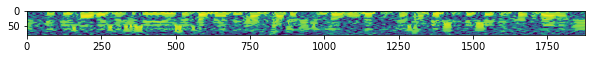

In [78]:
plt.figure(figsize=(10,20))
plt.imshow(recon_melspec.squeeze().cpu().numpy().reshape(bach_audio.shape))

In [79]:
recon_ground_truth = torchaudio.transforms.AmplitudeToDB()(ground_truth)

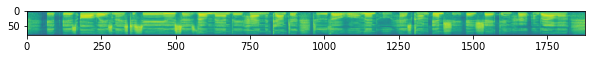

In [80]:
plt.figure(figsize=(10,20))
plt.imshow(recon_ground_truth.squeeze().cpu().numpy().reshape(bach_audio.shape))

In [85]:
# inverse stft
#recon_melspec = torchaudio.functional.DB_to_amplitude(recon_melspec, ref=1, power=0.5)
inverse_melspec = torchaudio.transforms.InverseMelScale(512, sample_rate=rate, n_mels=80).cuda()

In [86]:
transform = inverse_melspec(recon_melspec.reshape(bach_audio.shape))

In [89]:
grf = torchaudio.transforms.GriffinLim(n_fft=512).cuda()

In [94]:
a = grf(transform[:257])

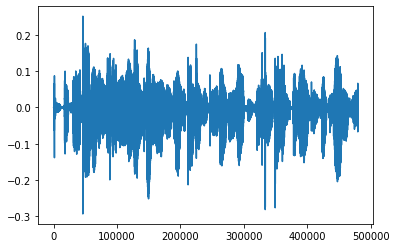

In [98]:
plt.plot(audio.squeeze())

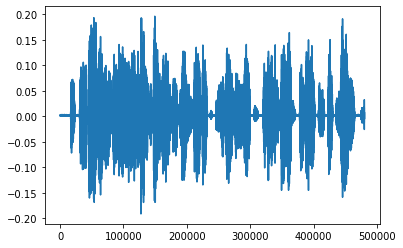

In [96]:
plt.plot(a.cpu())

In [102]:
Audio(a.cpu().detach().squeeze().numpy(),rate=rate)

In [ ]:
# librosa를 활용한 방법

In [100]:
import librosa
import soundfile

In [76]:


recon_melspec_numpy = recon_melspec.cpu().detach().numpy()
recon_melspec_numpy = librosa.db_to_amplitude(recon_melspec_numpy)
S = librosa.feature.inverse.mel_to_audio(recon_melspec_numpy, n_fft=512)

In [78]:
recon_melspec_numpy.shape

(1, 128, 1876)

In [77]:
S.shape

(1, 240000)

In [89]:
S

array([[-0.3388167 ,  0.32235208,  1.1411444 , ...,  0.24876854,
        -0.05224194,  0.3675938 ]], dtype=float32)

In [92]:
S_t = S.transpose()

In [93]:
S_t.shape

(240000, 1)

In [95]:
S_t = S_t.squeeze()

In [96]:
S_t.shape

(240000,)

In [91]:
y = librosa.griffinlim(S, n_fft=512)

ValueError: could not broadcast input array from shape (257,240000) into shape (1,240000)

In [101]:
soundfile.write("C:/Users/Yoon/Desktop/recon2.wav", a, samplerate=rate)

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

In [ ]:
torchaudio.save(os.path.join(datapath, '15000_SNR_recons_' + os.path.basename(wave)), model_output.squeeze(-1).cpu().float(), sample_rate=rate)
model_output = torchaudio.functional.resample(model_output.squeeze(-1), rate, 16000).squeeze().cpu()
model_input = torchaudio.functional.resample(model_input.squeeze(-1), rate, 16000).squeeze().cpu()

# model_output, _ = torchaudio.load(os.path.join(datapath, 'recons' + os.path.basename(wave)))
model_output = model_output.squeeze().numpy()
ground_truth = torchaudio.functional.resample(ground_truth.squeeze(-1), rate, 16000).squeeze().cpu()


In [ ]:
pesq.append(get_metrics(model_output, ground_truth.numpy(), model_output, sample_rate=16000, metrics_list=['pesq'])['pesq'])
print(pesq[-1])

In [ ]:
pesq

In [ ]:
print(max(pesq), min(pesq), np.mean(pesq))
plt.scatter(np.arange(len(pesq)), pesq)
plt.plot(np.ones_like(pesq) * 3)
plt.plot(np.ones_like(pesq) * 4)
print(pesq)